**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906). This
meta-analysis suggests that pretraining on test set features (no labels) can be okay.

**Estimated runtime**: ~10 minutes.

In [1]:
import os

import arviz as az
import bambi as bmb
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Load data

In [3]:
_dfs = []
for accuracy_csv in sorted(os.listdir("accuracies")):
    _df = pd.read_csv(os.path.join("accuracies", accuracy_csv))
    _df["dataset"] = accuracy_csv.removesuffix(".csv")
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [4]:
num_test = 200  # taken from bert/run.ipynb
num_correct_df = (accuracy_df.copy()[["base", "extra", "test"]] * num_test).astype(int, errors="raise")
num_correct_df["dataset"] = accuracy_df["dataset"].copy()
num_correct_df = num_correct_df[["dataset", "base", "extra", "test"]]
num_correct_df["pair"] = range(len(num_correct_df))

# Analysis code

In [5]:
def violin_plot(
    accuracy_df: pd.DataFrame,
    paired_diff_column: str,
    title: str,
    color,
    **ylabel_kwargs
):
    _, axes = plt.subplots(figsize=(16, 2))
    axes: plt.Axes
    sns.violinplot(
        data=accuracy_df, x="dataset", y=paired_diff_column, ax=axes, color=color
    )
    axes.set_title(title)
    axes.yaxis.grid(True)
    axes.set_xlabel("Text classification dataset")
    axes.set_ylabel(**ylabel_kwargs)
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [6]:
def eda(
    accuracy_df: pd.DataFrame,
    control_column: str,
    treatment_column: str,
    title: str,
    color,
    **ylabel_kwargs,
):
    accuracy_df = accuracy_df.copy()
    paired_diff_column = f"{treatment_column} - {control_column}"
    accuracy_df[paired_diff_column] = (
        accuracy_df[treatment_column] - accuracy_df[control_column]
    )
    violin_plot(accuracy_df, paired_diff_column, title, color, **ylabel_kwargs)
    summary = (
        accuracy_df.groupby("dataset")[paired_diff_column]
        .describe()[["mean", "std"]]
    )
    print(summary.mean())
    return summary.round(3)

In [7]:
def model(
    num_correct_df: pd.DataFrame, control_column: str, treatment_column: str
) -> tuple[bmb.Model, az.InferenceData]:
    df = (
        num_correct_df[["pair", "dataset", control_column, treatment_column]]
        .melt(["pair", "dataset"], var_name="method", value_name="num_correct")
        .sort_values("pair")
        .reset_index(drop=True)
    )
    model = bmb.Model(
        "num_correct ~ method + (1|pair) + (1|dataset)", family="poisson", data=df
    )
    fit_summary: az.InferenceData = model.fit(
        cores=1, inference_method="mcmc", chains=2
    )
    az_summary: pd.DataFrame = az.summary(fit_summary)
    display(
        az_summary.loc[
            [index_name for index_name in az_summary.index if "method" in index_name]
        ]
    )

    az.plot_trace(fit_summary, compact=False, var_names="method", filter_vars="like")
    return model, fit_summary

# Does pretraining help?

This is our control.

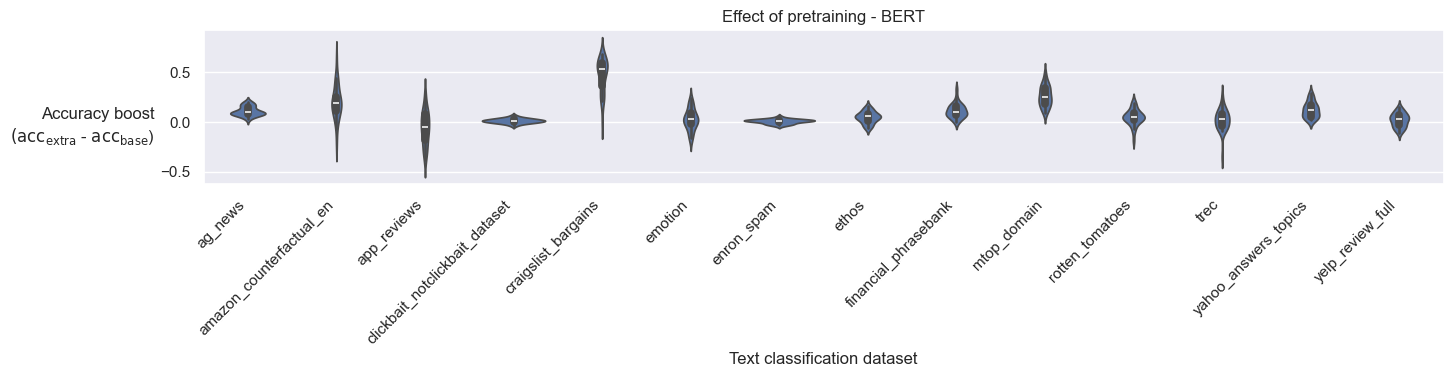

mean    0.099512
std     0.090765
dtype: float64


,mean,std
dataset,,
ag_news,0.109,0.047
amazon_counterfactual_en,0.200,0.171
app_reviews,-0.057,0.167
clickbait_notclickbait_dataset,0.012,0.023
craigslist_bargains,0.468,0.167
emotion,0.026,0.104
enron_spam,0.007,0.022
ethos,0.047,0.058
financial_phrasebank,0.112,0.071


In [8]:
eda(
    accuracy_df,
    control_column="base",
    treatment_column="extra",
    title="Effect of pretraining - BERT",
    color=None,
    ylabel=(
        "Accuracy boost\n$(\\text{acc}_\\text{extra}$ - $\\text{acc}_\\text{base}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="top",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, 1|pair_sigma, 1|pair_offset, 1|dataset_sigma, 1|dataset_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 216 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.177,0.007,0.164,0.189,0.0,0.0,2719.0,1418.0,1.0


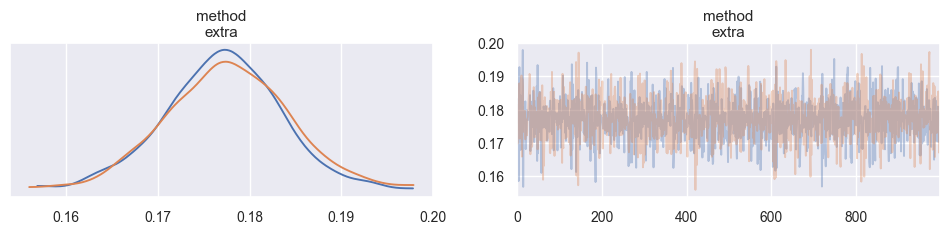

In [9]:
model_control, summary_control = model(
    num_correct_df, control_column="base", treatment_column="extra"
)

Good evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

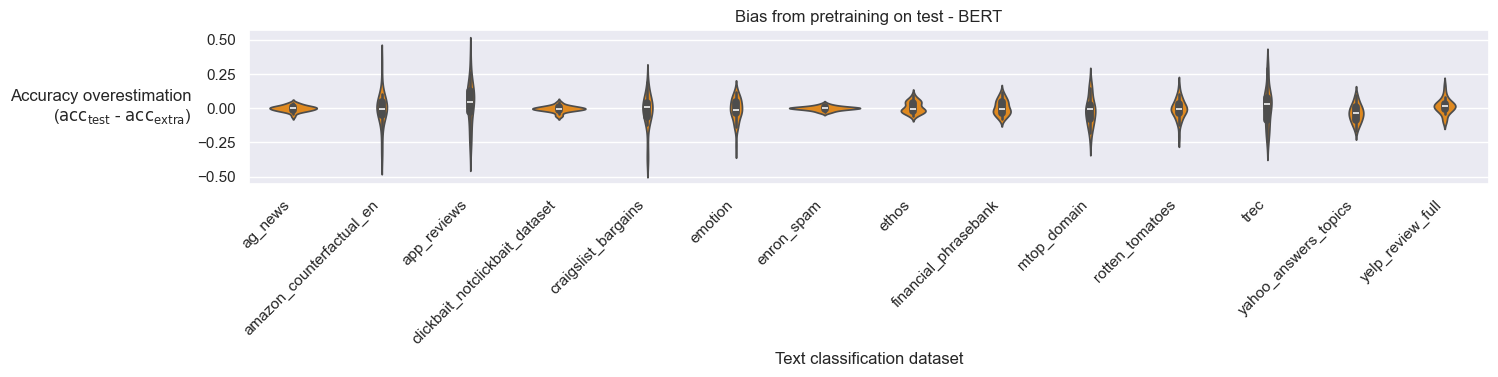

mean   -0.002571
std     0.076849
dtype: float64


,mean,std
dataset,,
ag_news,-0.001,0.022
amazon_counterfactual_en,-0.007,0.126
app_reviews,0.038,0.151
clickbait_notclickbait_dataset,-0.004,0.022
craigslist_bargains,-0.024,0.128
emotion,-0.013,0.086
enron_spam,-0.000,0.016
ethos,0.007,0.041
financial_phrasebank,0.005,0.053


In [10]:
eda(
    accuracy_df,
    control_column="extra",
    treatment_column="test",
    title="Bias from pretraining on test - BERT",
    color="darkorange",
    ylabel=(
        "Accuracy overestimation\n"
        "($\\text{acc}_\\text{test}$ - $\\text{acc}_\\text{extra}$)"
    ),
    rotation="horizontal",
    ha="right",
    va="center",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, 1|pair_sigma, 1|pair_offset, 1|dataset_sigma, 1|dataset_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 193 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],-0.004,0.006,-0.017,0.008,0.0,0.0,3359.0,1138.0,1.0


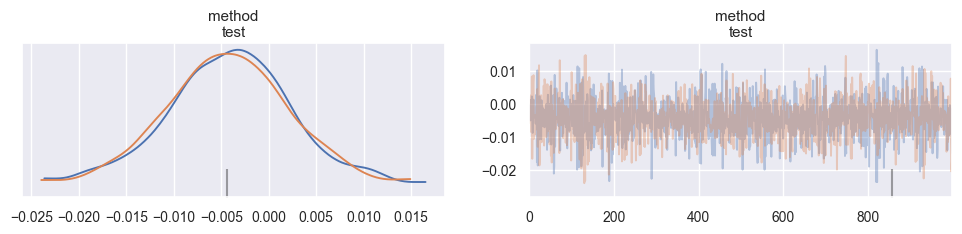

In [11]:
model_bias, summary_bias = model(
    num_correct_df, control_column="extra", treatment_column="test"
)

No evidence of bias. There's a tiny negative effect. But the data is too noisy to
support the preposterous statement that pretraining on test set texts hurts test set
performance compared to pretraining on independent texts.